# The Easy "Hard" Way: Cythonizing

In this notebook, we'll build on the previous work where we used SymPy's code printers to generate code for evaluating expressions numerically. As a layer of abstraction on top of C code printers, which generate snippets of code we can copy into a C program, we can generate a fully compilable C library. On top of this, we will see how to use Cython to compile such a library into a Python extension module so its computational routines can be called directly from Python.

**Learning Objectives**

After this lesson, you will be able to:

1. write a simple Cython function and run it a Jupyter notebook using the `%%cython` magic command
2. use the SymPy `codegen` function to output compilable C code
3. wrap `codegen`-generated code with Cython, compile it into an extension module, and call it from Python
4. use SymPy's `autowrap` function to do all of this behind the scenes
5. pass a custom code printer to `autowrap` to make use of an external C library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
sym.init_printing()

## 1. A Quick Introduction to Cython

[Cython](http://cython.org/) is a **compiler** and a **programming language** used to generate C [extension modules](https://docs.python.org/3.6/extending/extending.html) for Python.

The Cython *language* is a Python/C [creole](https://en.wikipedia.org/wiki/Creole_language) which is essentially Python with some additional keywords for specifying static data types. It looks something like this:

```cython
def cython_sum(int n):
    cdef float s = 0.0
    cdef int i
    for i in range(n):
        s += i
    return s
```

The Cython *compiler* transforms this code into a "flavor" of C specific to Python extension modules. This C code is then compiled into a binary file that can be imported and used just like a regular Python module -- the difference being that the functions you use from that module can potentially be much faster and more efficient than an equivalent pure Python implementation.

Aside from writing Cython code for computations, Cython is commonly used for writing *wrappers* around existing C code so that the functions therein can be made available in an extension module as described above. We will use this technique to make the SymPy-generated C code accessible to Python for use in SciPy's `odeint`.

### Example

As a quick demonstration of what Cython can offer, we'll walk through a simple example of generating numbers in the [Fibonacci sequence](https://en.wikipedia.org/wiki/Fibonacci_number). If you're not familiar with it already, the sequence is initialized with $F_0 = 0$ and $F_1 = 1$, then the remaining terms are defined recursively by:

$$
F_i = F_{i-1} + F_{i-2}
$$


Our objective is to write a function that computes the $n$-th Fibonacci number. Let's start by writing a simple iterative solution in pure Python.

In [2]:
def python_fib(n):
    a = 0.0
    b = 1.0
    for i in range(n):
        tmp = a
        a = a + b
        b = tmp
    return a

In [3]:
[python_fib(i) for i in range(10)]

Let's see how long it takes to compute the 100th Fibonacci number.

In [4]:
%timeit python_fib(100)

11 µs ± 412 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now let's implement the same thing with Cython. Since Cython is essentially "Python with types," it is often fairly easy to make the move and see improvements in speed. It does come at the cost, however, of a separate compilation step.

There are [several ways to ways to go about the compilation process](http://docs.cython.org/en/latest/src/quickstart/build.html), and in many cases, Cython's tooling makes it fairly simple. For example, Jupyter notebooks can make use of a `%%cython` magic command that will do all of compilation in the background for us. To make use of it, we need to load the `cython` extension.

In [5]:
%load_ext cython

Now we can write a Cython function.

*Note: the `--annotate` (or `-a`) flag of the `%%cython` magic command will produce an interactive annotated printout of the Cython code, allowing us to see the C code that is generated.*

In [6]:
%%cython
def cython_fib(int n):
    cdef double a = 0.0
    cdef double b = 1.0
    cdef double tmp
    for i in range(n):
        tmp = a
        a = a + b
        b = tmp
    return a

In [7]:
%timeit cython_fib(100)

273 ns ± 14.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


To see a bit more about writing Cython and its potential performance benefits, see [this Cython examples notebook](cython-examples.ipynb).

Even better, check out Kurt Smith's [Cython tutorial](https://github.com/kwmsmith/scipy-2017-cython-tutorial) which is happening at the same time as this tutorial.

## 2. Generating C Code with SymPy's `codegen()`

Our main goal in using Cython is to wrap SymPy-generated C code into a Python extension module so that we can call the fast compiled numerical routines from Python.

SymPy's `codegen` function takes code *printing* a step further: it wraps a snippet of code that numerically evaluates an expression with a function, and puts that function into the context of a file that is fully ready-to-compile code.

Here we'll revisit the water radiolysis system, with the aim of numerically computing the right hand side of the system of ODEs and integrating using SciPy's `odeint`.

Recall that this system looks like:

$$
\begin{align}
\frac{dy_0(t)}{dt} &= f_0\left(y_0,\,y_1,\,\dots,\,y_{13},\,t\right) \\
&\vdots \\
\frac{dy_{13}(t)}{dt} &= f_{13}\left(y_0,\,y_1,\,\dots,\,y_{13},\,t\right)
\end{align}
$$

where we are representing our state variables $y_0,\,y_1,\dots,y_{13}$ as a vector $\mathbf{y}(t)$ that we called `states` in our code, and the collection of functions on the right hand side $\mathbf{f}(\mathbf{y}(t))$ we called `rhs_of_odes`.

Start by importing the system of ODEs and the matrix of state variables.

In [8]:
from scipy2017codegen.chem import load_large_ode
rhs_of_odes, states = load_large_ode()
rhs_of_odes[0]

Now we'll use `codegen` (under `sympy.utilities.codegen`) to output C source and header files which can compute the right hand side (RHS) of the ODEs numerically, given the current values of our state variables. Here we'll import it and show the documentation:

In [9]:
from sympy.utilities.codegen import codegen
#codegen?

We just have one expression we're interested in computing, and that is the matrix expression representing the derivatives of our state variables with respect to time: `rhs_of_odes`. What we want `codegen` to do is create a C function that takes in the current values of the state variables and gives us back each of the derivatives.

In [10]:
[(cf, cs), (hf, hs)] = codegen(('c_odes', rhs_of_odes), language='c')

Note that we've just expanded the outputs into individual variables so we can access the generated code easily. `codegen` gives us back the `.c` filename and its source code in a tuple, and the `.h` filename and its source in another tuple. Let's print the source code.

In [11]:
print(cs)

/******************************************************************************
 *                       Code generated with sympy 1.1                        *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "c_odes.h"
#include <math.h>

void c_odes(double y0, double y1, double y10, double y11, double y12, double y13, double y2, double y3, double y4, double y5, double y6, double y7, double y8, double y9, double *out_8217631274941320402) {

   out_8217631274941320402[0] = -14520000.0*pow(y0, 2) - 0.0158*y0*y1 - 20900000.0*y0*y11 - 27600000.0*y0*y4 - 35500000.0*y0*y5 - 13600000.0*y0*y6 - 22900000.0*y0*y7 - 13000000.0*y0*y8 - 1300000

There are several things here worth noting:

- the state variables are passed in individually
- the state variables in the function signature are out of order
- the output array is passed in as a pointer like in our Fibonacci sequence example, but it has an auto-generated name

Let's address the first issue first. Similarly to what we did in the C printing exercises, let's use a `MatrixSymbol` to represent our state vector instead of a matrix of individual state variable symbols (i.e. `y[0]` instead of `y0`). First, create the `MatrixSymbol` object that is the same shape as our states matrix.

In [12]:
y = sym.MatrixSymbol('y', *states.shape)

Now we need to replace the use of `y0`, `y1`, etc. in our `rhs_of_odes` matrix with the elements of our new state vector (e.g. `y[0]`, `y[1]`, etc.). We saw how to do this already in [the previous notebook](07-the-hard-way.ipynb). Start by forming a mapping from `y0 -> y[0, 0]`, `y1 -> y[1, 0]`, etc.

In [13]:
state_array_map = dict(zip(states, y))
state_array_map

Now replace the symbols in `rhs_of_odes` according to the mapping.  We'll call it `rhs_of_odes_ind` and use that from now on.

In [14]:
rhs_of_odes_ind = rhs_of_odes.xreplace(state_array_map)
rhs_of_odes_ind[0]

**Exercise**: use `codegen` again, but this time with `rhs_of_odes_ind` which makes use of a state vector rather than a container of symbols. Check out the resulting code. What is different about the function signature?

```python
[(cf, cs), (hf, hs)] = codegen(???)
```

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

In [15]:
[(cf, cs), (hf, hs)] = codegen(('c_odes', rhs_of_odes_ind), language='c')
print(cs)

/******************************************************************************
 *                       Code generated with sympy 1.1                        *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "c_odes.h"
#include <math.h>

void c_odes(double *y, double *out_9179669559960495482) {

   out_9179669559960495482[0] = -14520000.0*pow(y[0], 2) - 0.0158*y[0]*y[1] - 27600000.0*y[0]*y[4] - 35500000.0*y[0]*y[5] - 13600000.0*y[0]*y[6] - 22900000.0*y[0]*y[7] - 13000000.0*y[0]*y[8] - 13000000.0*y[0]*y[9] - 20900000.0*y[0]*y[11] + 24400.0*y[2]*y[4] + 5.83*y[4] + 0.0854;
   out_9179669559960495482[1] = -14520000.0*pow(y[0], 2) - 0.

So by re-writing our expression in terms of a `MatrixSymbol` rather than individual symbols, the function signature of the generated code is cleaned up greatly.

However, we still have the issue of the auto-generated output variable name. To fix this, we can form a matrix *equation* rather than an expression. The name given to the symbol on the left hand side of the equation will then be used for our output variable name.

We'll start by defining a new `MatrixSymbol` that will represent the left hand side of our equation -- the derivatives of each state variable.

In [16]:
dY = sym.MatrixSymbol('dY', *y.shape)

**Exercise**: form an equation using `sym.Eq` to equate the two sides of our system of differential equations, then use this as the expression in `codegen`. Print out just the *header* source to see the function signature. What is the output argument called now?

```python
ode_eq = sym.Eq(???)
[(cf, cs), (hf, hs)] = codegen(???)
print(???)
```

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

In [17]:
ode_eq = sym.Eq(dY, rhs_of_odes_ind)
[(cf, cs), (hf, hs)] = codegen(('c_odes', ode_eq), language='c')
print(hs)

/******************************************************************************
 *                       Code generated with sympy 1.1                        *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/


#ifndef PROJECT__C_ODES__H
#define PROJECT__C_ODES__H

void c_odes(double *y, double *dY);

#endif




Now we see that the `c_odes` function signature is nice and clean. We pass it a pointer to an array representing the current values of all of our state variables and a pointer to an array that we want to fill with the derivatives of each of those state variables.

If you're not familiar with C and pointers, you just need to know that it is idiomatic in C to preallocate a block of memory representing an array, then pass the *location* of that memory (and usually the number of elements it can hold), rather than passing the array itself to/from a function. For our purposes, this is as complicated as pointers will get.

Just so we can compile this code and use it, we'll re-use the `codegen` call above with `to_files=True` so the `.c` and `.h` files are actually written to the filesystem, rather than having their contents returned in a string.

In [18]:
codegen(('c_odes', ode_eq), language='c', to_files=True)

## 3. Wrapping the Generated Code with Cython

Now we want to wrap the function that was generated `c_odes` with a Cython function so we can generate an extension module and call that function from Python. Wrapping a set of C functions involves writing a Cython script that specifies the Python interface to the C functions. This script must do two things:

1. specify the function signatures as found in the C source
2. implement the Python interface to the C functions by wrapping them

The build system of Cython is able to take the Cython wrapper source code as well as the C library source code and compile/link things together into a Python extension module. We will write our wrapper code in a cell making use of the magic command `%%cython_pyximport`, which does a few things for us:

- writes the contents of the cell to a Cython source file (`modname.pyx`)
- looks for a `modname.pyxbld` file for instructions on how to build things
- builds everything into an extension module
- imports the extension module, making the functions declared there available in the notebook

So, it works similarly to the `%%cython` magic command we saw at the very beginning, but things are a bit more complicated now because we have this external library `c_odes` that needs to be compiled as well.

*Note: The `pyxbld` file contains code similar to what would be found in the `setup.py` file of a package making use of Cython code for wrapping C libraries.*

In either case, all that's needed is to tell setuptools/Cython:

- the name of the extension module we want to make
- the location of the Cython and C source files to be built
- the location of headers needed during compilation -- both our C library's headers as well as NumPy's headers

We will call our extension module `cy_odes`, so here we'll generate a `cy_odes.pyxbld` file to specify how to build the module.

In [19]:
%%writefile cy_odes.pyxbld
import numpy

#            module name specified by `%%cython_pyximport` magic
#            |        just `modname + ".pyx"`
#            |        |
def make_ext(modname, pyxfilename):
    from setuptools.extension import Extension
    return Extension(modname,
                     sources=[pyxfilename, 'c_odes.c'],
                     include_dirs=['.', numpy.get_include()])

Overwriting cy_odes.pyxbld


Now we can write our wrapper code.

To write the wrapper, we first write the function signature as specified by the C library. Then, we create a *wrapper function* that makes use of the C implementation and returns the result. This wrapper function becomes the interface to the compiled code, and it does not need to be identical to the C function signature. In fact, we'll make our wrapper function compliant with the `odeint` interface (i.e. takes a 1-dimensional array of state variable values and the current time).

In [20]:
%%cython_pyximport cy_odes
import numpy as np
cimport numpy as cnp # cimport gives us access to NumPy's C API

# here we just replicate the function signature from the header
cdef extern from "c_odes.h":
    void c_odes(double *y, double *dY)

# here is the "wrapper" signature that conforms to the odeint interface
def cy_odes(cnp.ndarray[cnp.double_t, ndim=1] y, double t):
    # preallocate our output array
    cdef cnp.ndarray[cnp.double_t, ndim=1] dY = np.empty(y.size, dtype=np.double)
    # now call the C function
    c_odes(<double *> y.data, <double *> dY.data)
    # return the result
    return dY

**Exercise**: use `np.random.randn` to generate random state variable values and evaluate the right-hand-side of our ODEs with those values.

```python
random_vals = np.random.randn(???)
???
```

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

In [21]:
random_vals = np.random.randn(14)
cy_odes(random_vals, 0) # note: any time value will do

array([-23724082.92329195,  25807242.39163674, -13028363.50647634,
       -23546532.74489197,  32214175.33858155, -13137710.61621235,
       -25503988.3961327 , -21960251.58311209,  72093072.28562741,
       -55996179.32494314,  40456959.87694598,  55977675.73158015,
       -20819668.00912874,    999758.0079038 ])

Now we can use `odeint` to integrate the equations and plot the results to check that it worked. First we need to import `odeint`.

In [22]:
from scipy.integrate import odeint

A couple convenience functions are provided in the `scipy2017codegen` package which give some reasonable initial conditions for the system and plot the state trajectories, respectively. Start by grabbing some initial values for our state variables and time values.

In [23]:
from scipy2017codegen.chem import watrad_init, watrad_plot
y_init, t_vals = watrad_init()

Finally we can integrate the equations using our Cython-wrapped C function and plot the results.

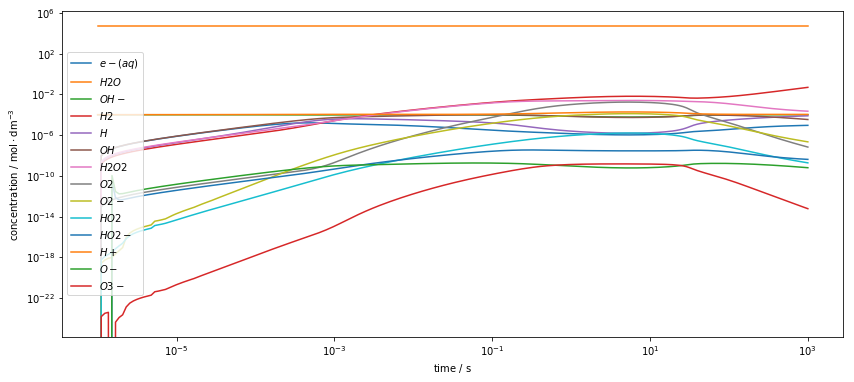

In [24]:
y_vals = odeint(cy_odes, y_init, t_vals)
watrad_plot(t_vals, y_vals)

## 4. Generating and Compiling a C Extension Module Automatically

As yet another layer of abstraction on top of `codegen`, SymPy provides an `autowrap` function that can *automatically generate* a Cython wrapper for the generated C code. This greatly simplifies the process of going from a SymPy expression to numerical computation, but as we'll see, we lose a bit of flexibility compared to manually creating the Cython wrapper.

Let's start by importing the `autowrap` function and checking out its documentation.

In [25]:
from sympy.utilities.autowrap import autowrap
#autowrap?

So `autowrap` takes in a SymPy expression and gives us back a binary callable which evaluates the expression numerically. Let's use the `Equality` formed earlier to generate a function we can call to evaluate the right hand side of our system of ODEs.

In [26]:
auto_odes = autowrap(ode_eq, backend='cython', tempdir='./autowraptmp')

**Exercise**: use the main Jupyter notebook tab to head to the temporary directory `autowrap` just created. Take a look at some of the files it contains. Can you map everything we did manually to the files generated?

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

`autowrap` generates quite a few files, but we'll explicitly list a few here:

- `wrapped_code_#.c`: the same thing `codegen` generated
- `wrapper_module_#.pyx`: the Cython wrapper code
- `wrapper_module_#.c`: the cythonized code
- `setup.py`: specification of the `Extension` for how to build the extension module

**Exercise**: just like we did before, generate some random values for the state variables and use `auto_odes` to compute the derivatives. Did it work like before?

*Hint: take a look at `wrapper_module_#.pyx` to see the types of the arrays being passed in / created.*

```python
random_vals = np.random.randn(???)
auto_odes(???)
```

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

In [27]:
random_vals = np.random.randn(14, 1) # need a 2-dimensional vector
auto_odes(random_vals)

array([[  3.59754533e+07],
       [  8.75967845e+07],
       [ -1.14436306e+08],
       [  7.14307596e+06],
       [ -5.54176643e+06],
       [ -4.09999851e+06],
       [  9.99981924e+06],
       [  8.74003921e+06],
       [  1.64097236e+07],
       [ -1.68809875e+07],
       [ -8.92128506e+06],
       [ -5.95990164e+07],
       [  1.09376457e+07],
       [  4.35751626e+05]])

One advantage to wrapping the generated C code manually is that we get fine control over how the function is used from Python. That is, in our hand-written Cython wrapper we were able to specify that from the Python side, the input to our wrapper function and its return value are both 1-dimensional `ndarray` objects. We were also able to add in the extra argument `t` for the current time, making the wrapper function fully compatible with `odeint`.

However, `autowrap` just sees that we have a matrix equation where each side is a 2-dimensional array with shape (14, 1). The function returned then expects the input array to be 2-dimensional and it returns a 2-dimensional array.

This won't work with `odeint`, so we can write a simple wrapper that massages the input and output and adds an extra argument for `t`.

In [28]:
def auto_odes_wrapper(y, t):
    dY = auto_odes(y[:, np.newaxis])
    return dY.squeeze()

Now a 1-dimensional input works.

In [29]:
random_vals = np.random.randn(14)
auto_odes_wrapper(random_vals, 0)

array([-52235794.27218003, -32286519.97217096, -50603871.7020881 ,
        37531598.33115227, -92836473.67561042,  75390511.90717517,
       -22247462.01490881, -91997102.50683887,  96034933.33310629,
       -63439029.98752794,  88759082.21797253,  76734548.55263379,
        -4469220.37815491,   -750580.64602198])

**Exercise**: As we have seen previously, we can analytically evaluate the Jacobian of our system of ODEs, which can be helpful in numerical integration. Compute the Jacobian of `rhs_of_odes_ind` with respect to `y`, then use `autowrap` to generate a function that evaluates the Jacobian numerically. Finally, write a Python wrapper called `auto_jac_wrapper` to make it compatible with `odeint`.

```python
# compute jacobian of rhs_of_odes_ind with respect to y
???

# generate a function that computes the jacobian
auto_jac = autowrap(???)

def auto_jac_wrapper(y, t):
    return ???
```

Test your wrapper by passing in the `random_vals` array from above. The shape of the result should be `(14, 14)`.

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

In [30]:
jac = rhs_of_odes_ind.jacobian(y)

auto_jac = autowrap(jac, backend='cython', tempdir='./autowraptmp')

def auto_jac_wrapper(y, t):
    return auto_jac(y[:, np.newaxis])

auto_jac_wrapper(random_vals, 2).shape

Finally, we can use our two wrapped functions in `odeint` and compare to our manually-written Cython wrapper result.

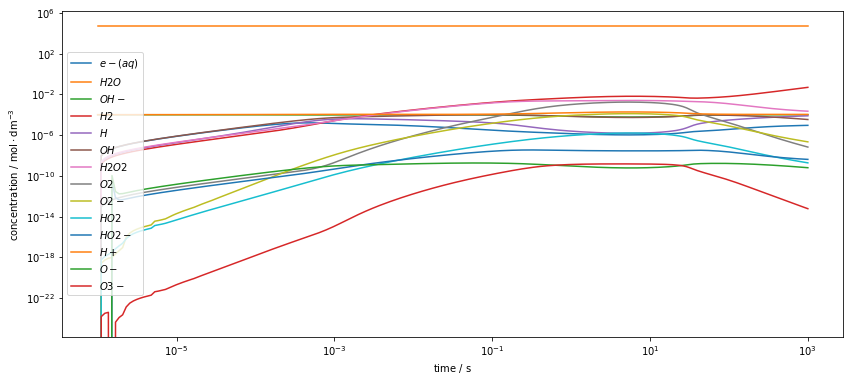

In [31]:
y_vals = odeint(auto_odes_wrapper, y_init, t_vals, Dfun=auto_jac_wrapper)
watrad_plot(t_vals, y_vals)

## 5. Using a Custom Printer and an External Library with `autowrap`

As of SymPy 1.1, `autowrap` accepts a custom `CodeGen` object, which is responsible for generating the code. The `CodeGen` object in turn accepts a custom `CodePrinter` object, meaning we can use these two points of flexibility to make use of customized code printing in an autowrapped function. The following example is somewhat contrived, but the concept in general is powerful.

In our set of ODEs, there are quite a few instances of $y_i^2$, where $y_i$ is one of the 14 state variables. As an example, here's the equation for $\frac{dy_3(t)}{dt}$:

In [32]:
rhs_of_odes[3]

There is a library called [fastapprox](https://github.com/romeric/fastapprox) that provides computational routines things like powers, exponentials, logarithms, and a few others. These routines provide limited precision with respect to something like `math.h`'s equivalent functions, but they offer potentially faster computation.

The fastapprox library provides a function called `fastpow`, with the signature `fastpow(float x, float p)`. It it follows the interface of `pow` from `math.h`. In the previous notebook, we saw how to turn instances of $x^3$ into `x*x*x`, which is potentially quicker than `pow(x, 3)`. Here, let's just use `fastpow` instead.

**Exercise**: implement a `CustomPrinter` class that inherits from `C99CodePrinter` and overrides the `_print_Pow` function to make use of `fastpow`. Test it by instantiating the custom printer and printing a SymPy expression $x^3$.

*Hint: it may be helpful to run `C99CodePrinter._print_Pow??` to see how it works*

```python
from sympy.printing.ccode import C99CodePrinter

class CustomPrinter(C99CodePrinter):
    def _print_Pow(self, expr):
        ???

printer = CustomPrinter()
x = sym.symbols('x')
# print x**3 using the custom printer
???
```

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

In [33]:
from sympy.printing.ccode import C99CodePrinter

class CustomPrinter(C99CodePrinter):
    def _print_Pow(self, expr):
        return "fastpow({}, {})".format(self._print(expr.base),
                                        self._print(expr.exp))

printer = CustomPrinter()
x = sym.symbols('x')
printer.doprint(x**3)

'fastpow(x, 3)'

Now we can create a `C99CodeGen` object that will make use of this printer. This object will be passed in to `autowrap` with the `code_gen` keyword argument, and `autowrap` will use it in the code generation process.

In [34]:
from sympy.utilities.codegen import C99CodeGen
gen = C99CodeGen(printer=printer)

However, for our generated code to use the `fastpow` function, it needs to have a `#include "fastpow.h"` preprocessor statement at the top. The code gen object supports this by allowing us to append preprocessor statements to its `preprocessor_statements` attribute.

In [35]:
gen.preprocessor_statements.append('#include "fastpow.h"')

One final issue remains, and that is telling `autowrap` where to find the fastapprox library headers. These header files have just been downloaded from GitHub and placed in the `scipy2017codegen` package, so it should be installed with the conda environment. We can find it by looking for the package directory.

In [36]:
import os
import scipy2017codegen

package_dir = os.path.dirname(scipy2017codegen.__file__)
fastapprox_dir = os.path.join(package_dir, 'fastapprox')

Finally we're ready to call `autowrap`. We'll just use `ode_eq`, the `Equality` we created before, pass in the custom `CodeGen` object, and tell `autowrap` where the fastapprox headers are located.

In [37]:
auto_odes_fastpow = autowrap(ode_eq,
                             code_gen=gen,
                             backend='cython',
                             include_dirs=[fastapprox_dir],
                             tempdir='autowraptmp_custom')

If we navigate to the tmp directory created, we can view the `wrapped_code_#.c` to see our custom printing in action.

As before, we need a wrapper function for use with `odeint`, but aside from that, everything should be in place.

/home/travis/miniconda3/envs/codegen17/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/travis/miniconda3/envs/codegen17/lib/python3.6/site-packages/numpy/ma/core.py:6468: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


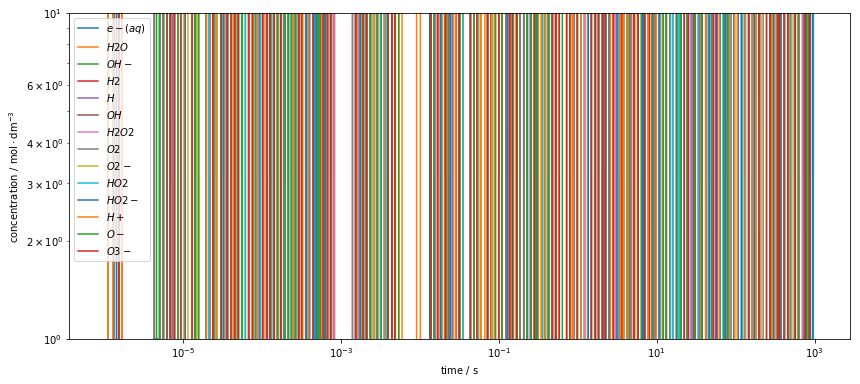

In [38]:
def auto_odes_fastpow_wrapper(y, t):
    dY = auto_odes_fastpow(y[:, np.newaxis])
    return dY.squeeze()

y_vals, info = odeint(auto_odes_fastpow_wrapper, y_init, t_vals, full_output=True)
watrad_plot(t_vals, y_vals)

**Exercise**: generate an array of random state variable values, then use this array in the `auto_odes_wrapper` and `auto_odes_fastpow_wrapper` functions. Compare their outputs.

**Solution**

```
|
|
|
|
|
|
|
|
|
|
v
```

In [39]:
random_vals = np.random.randn(14)
dY1 = auto_odes_wrapper(random_vals, 0)
dY2 = auto_odes_fastpow_wrapper(random_vals, 0)
dY1 - dY2

array([ -2.88572168e+03,  -2.88572168e+03,   2.88572168e+03,
         1.45423637e+03,  -2.27510552e+01,  -2.49060392e+03,
         1.24546277e+03,   1.60809077e-01,   0.00000000e+00,
        -3.21618155e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])